In [207]:
import numpy as np

def probality_to_Rx(probability: float):
    return 2 * np.arcsin(np.sqrt(probability))

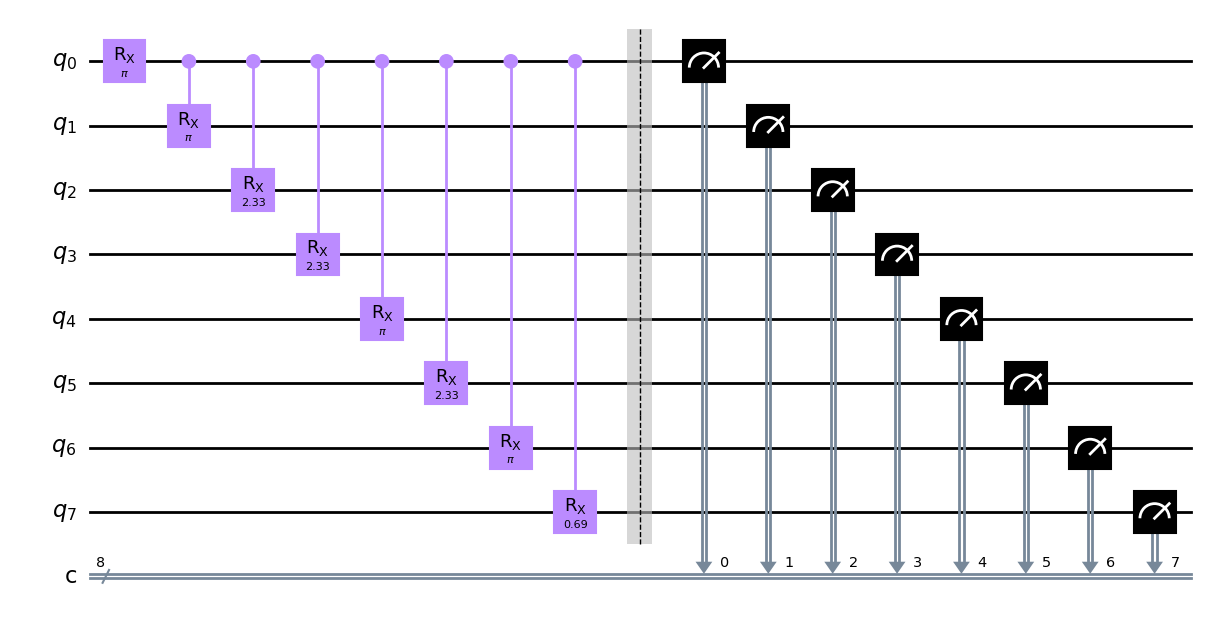

In [208]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from numpy import pi

# Use Aer's AerSimulator
simulator = AerSimulator()

circuit = QuantumCircuit(8, 8)

# services: 4647.66
# dense_housing: 16432.97
# scattered_housing: 15885.03
# transport: 437.36
# forests: 133.49
# grass: 411.35
# industrial: 3709.83

# P(flooding) = max(exp(4*hsea – 2))
h_sea = 0.916
P_flooding = min(1, np.e ** (4 * h_sea - 2))

# P(flooding area|flooding) = max(1, exp( 2*[hsea–harea] ) )
f = lambda h_area : min(1, np.e ** (2 * (h_sea - h_area)))
h_area_services = 0.5
h_area_dense_housing = 1
h_area_scattered_housing = 1
h_area_transport = 0.5
h_area_forests = 1
h_area_grass = 0.5
h_area_industrial = 2
P_flooding_services = f(h_area_services)
P_flooding_dense_housing = f(h_area_dense_housing)
P_flooding_scattered_housing = f(h_area_scattered_housing)
P_flooding_transport = f(h_area_transport)
P_flooding_forests = f(h_area_forests)
P_flooding_grass = f(h_area_grass)
P_flooding_industrial = f(h_area_industrial)

circuit.rx(probality_to_Rx(P_flooding), 0)
circuit.crx(probality_to_Rx(P_flooding_services), 0, 1)
circuit.crx(probality_to_Rx(P_flooding_dense_housing), 0, 2)
circuit.crx(probality_to_Rx(P_flooding_scattered_housing), 0, 3)
circuit.crx(probality_to_Rx(P_flooding_transport), 0, 4)
circuit.crx(probality_to_Rx(P_flooding_forests), 0,5)
circuit.crx(probality_to_Rx(P_flooding_grass), 0, 6)
circuit.crx(probality_to_Rx(P_flooding_industrial), 0, 7)

# Map the quantum measurement to the classical bits
circuit.barrier()
circuit.measure(list(range(8)), list(range(8)))

# Compile the circuit for the support instruction set (basis_gates)
# and topology (coupling_map) of the backend
compiled_circuit = transpile(circuit, simulator)

# Execute the circuit on the aer simulator
shots = 1000
job = simulator.run(compiled_circuit, shots=shots)

# Grab results from the job
result = job.result()

# Returns counts
counts = result.get_counts(compiled_circuit)

# Draw the circuit
circuit.draw("mpl")

In [209]:
def counts_to_probabilities(counts):
    d = dict()
    registers = len(list(counts.keys())[0])
    for i in range(registers):
        d[i] = 0
    for k, v in counts.items():
        for i, xd in enumerate(k):
            if k[i] == '1':
                d[registers - i - 1] += v
    return d


props = counts_to_probabilities(counts)
for i in props:
    props[i] /= shots / 100

props

{0: 100.0, 1: 100.0, 2: 82.4, 3: 86.2, 4: 100.0, 5: 85.3, 6: 100.0, 7: 11.8}

In [210]:
# services: 4647.66
# dense_housing: 16432.97
# scattered_housing: 15885.03
# transport: 437.36
# forests: 133.49
# grass: 411.35
# industrial: 3709.83

names = [
    'Flooding',
    'services',
    'dense_housing',
    'scattered_housing',
    'transport',
    'forests',
    'grass',
    'industrial',
]

props2 = dict()
for k, v in props.items():
    props2[names[k]] = v / 100

props2

{'Flooding': 1.0,
 'services': 1.0,
 'dense_housing': 0.8240000000000001,
 'scattered_housing': 0.862,
 'transport': 1.0,
 'forests': 0.853,
 'grass': 1.0,
 'industrial': 0.11800000000000001}

In [211]:
# services: 4647.66
# dense_housing: 16432.97
# scattered_housing: 15885.03
# transport: 437.36
# forests: 133.49
# grass: 411.35
# industrial: 3709.83

costs_per_area = {
    'Flooding': 200,
    'services': 4647.66,
    'dense_housing': 16432.97,
    'scattered_housing': 15885.03,
    'transport': 437.36,
    'forests': 133.49,
    'grass': 411.35,
    'industrial': 3709.83,

}

destruction_level = 0.1
inflation_adjustment = 1.579
for k, v in costs_per_area.items():
    costs_per_area[k] *= destruction_level * inflation_adjustment

for k, v in costs_per_area.items():
    costs_per_area[k] = round(v, 2)

costs_per_area

{'Flooding': 31.58,
 'services': 733.87,
 'dense_housing': 2594.77,
 'scattered_housing': 2508.25,
 'transport': 69.06,
 'forests': 21.08,
 'grass': 64.95,
 'industrial': 585.78}

In [212]:
expected_costs = 0
for k, v in props2.items():
    expected_costs += costs_per_area[k] * v
expected_costs = round(expected_costs, 2)

print(f'Cost: {expected_costs} mln zł!!!')

Cost: 5286.77 mln zł!!!


In [213]:
G = 3943

def PexceedG(V, G):
    d = 0.3
    A = (d * V) ** 2 * 0.5
    if V > G:
        Aover = A - max(0, G - (1 - d) * V) ** 2 * 0.5
    else:
        Aover = max(0, (1 + d) * V - G) ** 2 * 0.5
    return Aover / A
    

print(f'The probability of a greater loss than the city budget 3 943 mln PLN is {int(PexceedG(expected_costs, G) * 100)}%')

The probability of a greater loss than the city budget 3 943 mln PLN is 97%
